# Portugal - ARIMA

# Instalando Dependências e Importando Bibliotecas

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# from xgboost import XGBRegressor
from pmdarima.arima import auto_arima, ADFTest
import matplotlib.pylab as plt

# Série temporal do Covid19 em Portugal

In [ ]:
# importando  Dataset
df_pt = pd.read_csv("https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data.csv")

In [ ]:
# Redefinindo o tipo do campo de data
df_pt['data'] = pd.to_datetime(df_pt['data'])
df_pt['data_dados'] = pd.to_datetime(df_pt['data_dados'])

In [ ]:
df_pt.head()

,data,data_dados,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,cadeias_transmissao,transmissao_importada,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,...,obitos_acores,obitos_madeira,obitos_estrangeiro,recuperados_arsnorte,recuperados_arscentro,recuperados_arslvt,recuperados_arsalentejo,recuperados_arsalgarve,recuperados_acores,recuperados_madeira,recuperados_estrangeiro,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,confirmados_desconhecidos_m,confirmados_desconhecidos_f,ativos,internados_enfermaria,confirmados_desconhecidos,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
0,2020-02-26,2020-02-26,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-27,2020-02-27,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,NaN,NaN,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-28,2020-02-28,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-29,2020-02-29,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-03,2020-01-03,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_pt.tail()

,data,data_dados,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,cadeias_transmissao,transmissao_importada,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,...,obitos_acores,obitos_madeira,obitos_estrangeiro,recuperados_arsnorte,recuperados_arscentro,recuperados_arslvt,recuperados_arsalentejo,recuperados_arsalgarve,recuperados_acores,recuperados_madeira,recuperados_estrangeiro,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,confirmados_desconhecidos_m,confirmados_desconhecidos_f,ativos,internados_enfermaria,confirmados_desconhecidos,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
720,2022-02-15,2022-02-15,3111858,1193144,460711,1104515,108356,124380,48691,72061,NaN,18135,2554403,20620,2270.0,147.0,NaN,NaN,574788.0,NaN,NaN,NaN,157821.0,165229.0,206105.0,207931.0,247817.0,230767.0,267819.0,226325.0,300511.0,241967.0,204983.0,167948.0,121386.0,106141.0,71543.0,62936.0,79448.0,42414.0,...,80,177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,8.0,11.0,22.0,33.0,85.0,130.0,184.0,426.0,590.0,1307.0,1691.0,2769.0,7191.0,6167.0,9774.0,10846.0,NaN,NaN,536835.0,2123.0,2767.0,4989.6,5000.0,0.81,0.80
721,2022-02-16,2022-02-16,3131899,1198738,464530,1111346,109416,125751,49488,72630,NaN,20041,2574750,20666,2141.0,142.0,NaN,NaN,561116.0,NaN,NaN,NaN,158957.0,166450.0,207911.0,209715.0,249393.0,232137.0,269462.0,227535.0,302363.0,243241.0,206117.0,168737.0,122144.0,106691.0,72091.0,63355.0,80086.0,42722.0,...,80,179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,8.0,11.0,22.0,33.0,85.0,132.0,185.0,427.0,591.0,1308.0,1697.0,2770.0,7209.0,6182.0,9800.0,10866.0,NaN,NaN,536483.0,1999.0,2792.0,4390.9,4385.9,0.76,0.75
722,2022-02-17,2022-02-17,3148387,1203128,467675,1117071,110358,126749,50231,73175,NaN,16488,2589510,20708,2022.0,132.0,NaN,NaN,545242.0,NaN,NaN,NaN,159831.0,167337.0,209413.0,211125.0,250871.0,233248.0,270814.0,228521.0,303828.0,244273.0,207059.0,169435.0,122769.0,107216.0,72525.0,63713.0,80607.0,42996.0,...,81,181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,8.0,11.0,22.0,33.0,85.0,133.0,185.0,430.0,592.0,1310.0,1700.0,2775.0,7221.0,6197.0,9816.0,10892.0,NaN,NaN,538169.0,1890.0,2806.0,4390.9,4385.9,0.76,0.75
723,2022-02-18,2022-02-18,3163869,1207201,470689,1122343,111284,127770,50881,73701,NaN,15482,2626220,20759,1936.0,127.0,NaN,NaN,534151.0,NaN,NaN,NaN,160622.0,168173.0,210848.0,212476.0,252152.0,234289.0,272075.0,229465.0,305285.0,245199.0,207949.0,170044.0,123379.0,107738.0,72946.0,64063.0,81088.0,43265.0,...,83,182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,8.0,11.0,22.0,33.0,85.0,134.0,185.0,431.0,592.0,1314.0,1704.0,2785.0,7237.0,6212.0,9836.0,10923.0,NaN,NaN,516890.0,1809.0,2813.0,3853.1,3833.4,0.74,0.73
724,2022-02-19,2022-02-19,3178029,1210395,473313,1126848,112191,128606,52406,74270,NaN,14160,2653048,20796,1799.0,118.0,NaN,NaN,521186.0,NaN,NaN,NaN,161338.0,168899.0,212162.0,213660.0,253197.0,235175.0,273202.0,230335.0,306586.0,246174.0,208848.0,170675.0,123939.0,108223.0,73355.0,64413.0,81506.0,43515.0,...,83,182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,8.0,11.0,22.0,33.0,85.0,134.0,186.0,432.0,593.0,1315.0,1710.0,2790.0,7246.0,6225.0,9853.0,10943.0,NaN,NaN,504185.0,1681.0,2827.0,3853.1,3833.4

In [ ]:
df_pt[df_pt['data'] == '2021-06-01']['internados']

315    3293.0
Name: internados, dtype: float64

In [ ]:
start_date = '2020-02-26'
final_date = '2022-01-31'

In [ ]:
df_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 93 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   data                               725 non-null    datetime64[ns]
 1   data_dados                         725 non-null    datetime64[ns]
 2   confirmados                        725 non-null    int64         
 3   confirmados_arsnorte               725 non-null    int64         
 4   confirmados_arscentro              725 non-null    int64         
 5   confirmados_arslvt                 725 non-null    int64         
 6   confirmados_arsalentejo            725 non-null    int64         
 7   confirmados_arsalgarve             725 non-null    int64         
 8   confirmados_acores                 725 non-null    int64         
 9   confirmados_madeira                725 non-null    int64         
 10  confirmados_estrangeiro            16 

In [ ]:
round(df_pt.describe(), 2)

,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,cadeias_transmissao,transmissao_importada,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,...,obitos_acores,obitos_madeira,obitos_estrangeiro,recuperados_arsnorte,recuperados_arscentro,recuperados_arslvt,recuperados_arsalentejo,recuperados_arsalgarve,recuperados_acores,recuperados_madeira,recuperados_estrangeiro,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,confirmados_desconhecidos_m,confirmados_desconhecidos_f,ativos,internados_enfermaria,confirmados_desconhecidos,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
count,725.00,725.00,725.00,725.00,725.00,725.00,725.00,725.00,16.00,725.00,725.00,725.00,717.00,708.00,164.00,173.00,718.00,155.00,15.00,167.00,718.00,718.00,718.00,718.00,718.00,718.00,718.00,718.00,718.00,718.00,718.00,718.00,718.00,718.00,718.00,718.00,718.00,718.00,167.00,167.00,...,725.00,725.00,31.0,10.00,10.0,10.00,10.0,10.0,10.0,10.0,10.0,697.00,697.00,697.00,697.00,697.00,697.00,697.00,697.00,697.00,697.00,697.00,697.00,696.00,696.00,696.00,696.00,696.00,696.00,698.00,698.00,76.00,76.00,720.00,720.00,669.00,340.00,340.00,340.00,340.00
mean,666052.45,262888.66,90937.59,252527.63,22827.23,22500.79,5465.08,8905.26,9.12,4383.49,585848.53,10583.74,1240.22,194.17,2210.07,258703.39,79069.68,254759.04,12.20,640.63,21769.06,22718.96,34986.57,34824.20,53918.60,50118.92,53609.22,46515.99,61642.61,49674.20,51847.43,41317.77,32482.99,29611.41,20875.50,18543.94,30804.47,15501.17,0.44,0.34,...,27.70,45.79,0.0,10.80,9.1,13.90,0.0,0.0,0.0,0.0,0.0,0.79,0.83,0.72,0.61,3.44,4.83,12.31,14.71,41.87,63.66,90.82,218.93,301.03,686.54,875.59,1459.25,3915.50,3305.43,5240.19,5752.86,27.22,20.05,70103.65,1044.04,648.17,841.07,842.40,1.04,1.04
std,643412.73,243625.75,92166.14,239719.53,22797.34,25916.58,8134.03,14042.41,5.86,9998.00,551377.62,7758.81,1375.13,193.06,1387.71,157914.29,119310.22,123634.45,7.69,249.60,28394.09,29652.38,39289.17,39513.02,52144.01,49716.31,53135.71,46138.32,60316.74,49136.66,45776.31,37392.03,28028.29,25241.87,17248.71,15267.82,22888.63,11716.35,0.11,0.11,...,16.25,46.41,0.0,6.71,1.2,4.48,0.0,0.0,0.0,0.0,0.0,0.41,0.85,0.63,0.49,2.22,3.30,8.79,11.73,28.54,44.75,63.33,151.37,212.39,482.22,615.31,1031.97,2673.54,2288.89,3603.17,4014.39,14.59,9.23,116100.65,1192.17,1057.09,1714.00,1715.32,0.12,0.13
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,9.00,9.00,30.00,25.00,81.00,1746.00,4.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.10,0.15,...,0.00,0.00,0.0,3.00,7.0,4.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,0.00,4.00,0.00,5.00,9.00,12.00,10.00,23.00,0.00,0.00,2.00,0.00,-152.00,50.30,47.50,0.74,0.73
25%,55912.00,20021.00,4677.00,28932.00,898.00,1039.00,204.00,141.00,5.00,388.00,41021.00,1805.00,407.00,70.00,1417.75,115158.00,25822.50,189274.00,6.00,707.00,1008.25,1150.25,1465.75,1321.50,4797.75,4227.75,4963.00,4501.00,5192.75,4287.25,4841.25,3708.75,3016.75,2711.75,2078.75,1853.75,4261.50,2061.25,0.36,0.28,...,15.00,0.00,0.0,3.00,8.0,11.00,0.0,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00,1.00,1.00,3.00,1.00,10.00,12.00,17.00,41.00,51.00,112.00,

## Ajustando as Features

### Excluindo features 

In [ ]:
df_pt = df_pt.drop(['data_dados', 'confirmados_estrangeiro', 'cadeias_transmissao', 
                    'obitos_estrangeiro','recuperados_arscentro','recuperados_arslvt',
                    'recuperados_arsalentejo','recuperados_arsalgarve','recuperados_acores', 'recuperados_arsnorte',
                    'recuperados_madeira','recuperados_estrangeiro','obitos_arsnorte',
                    'obitos_arscentro','obitos_arslvt','obitos_arsalentejo','obitos_arsalgarve',
                    'obitos_acores','obitos_madeira','confirmados_arsnorte', 'confirmados_arscentro',
                    'confirmados_arslvt', 'confirmados_arsalentejo','confirmados_arsalgarve', 'confirmados_acores', 
                    'confirmados_madeira', 'transmissao_importada', 'confirmados_desconhecidos', 
                    'confirmados_desconhecidos_m', 'confirmados_desconhecidos_f'
                   ], axis=1)

In [ ]:
df_pt.shape

(725, 63)

In [ ]:
df_pt.columns

Index(['data', 'confirmados', 'confirmados_novos', 'recuperados', 'obitos',
       'internados', 'internados_uci', 'lab', 'suspeitos', 'vigilancia',
       'n_confirmados', 'confirmados_0_9_f', 'confirmados_0_9_m',
       'confirmados_10_19_f', 'confirmados_10_19_m', 'confirmados_20_29_f',
       'confirmados_20_29_m', 'confirmados_30_39_f', 'confirmados_30_39_m',
       'confirmados_40_49_f', 'confirmados_40_49_m', 'confirmados_50_59_f',
       'confirmados_50_59_m', 'confirmados_60_69_f', 'confirmados_60_69_m',
       'confirmados_70_79_f', 'confirmados_70_79_m', 'confirmados_80_plus_f',
       'confirmados_80_plus_m', 'sintomas_tosse', 'sintomas_febre',
       'sintomas_dificuldade_respiratoria', 'sintomas_cefaleia',
       'sintomas_dores_musculares', 'sintomas_fraqueza_generalizada',
       'confirmados_f', 'confirmados_m', 'obitos_0_9_f', 'obitos_0_9_m',
       'obitos_10_19_f', 'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m',
       'obitos_30_39_f', 'obitos_30_39_m', 'obit

### Redefinindo algumas features utilizando a primeira diferença
* O objetivo é transformar os valores que representam o quantitativo acumulado diariamente no quantitativo diário

In [ ]:
# Fazendo cópia do Dataset orginal
df_pt_diff = df_pt.copy()
df_pt_diff.shape

(725, 63)

A coluna 'confirmados_0_9_m' possui uma lacuna em uma data crucial para os resultados por isso, está sendo feito o tratamento do NAN nesta coluna antes da aplicação da primeira diferença. A lacuna é para o registro 424 correspondente a data 2021-04-25

In [ ]:
df_pt_diff[df_pt_diff['confirmados_0_9_m'].isna()]

,data,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
0,2020-02-26,0,0,0,0,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-27,0,0,0,0,NaN,NaN,NaN,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-28,0,0,0,0,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-29,0,0,0,0,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-03,0,0,0,0,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-02-03,2,2,0,0,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN
424,2021-04-25,834442,478,792685,16965,348.0,98.0,NaN,NaN,24313.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455613.0,378523.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8056.0,8909.0,24792.0,250.0,72.1,68.3,0.98,0.99


In [ ]:
df_pt_diff.dropna(subset=['confirmados_0_9_m'], axis=0,inplace=True)
df_pt_diff.reset_index(inplace=True, drop=True)

In [ ]:
df_pt_diff.shape

(718, 63)

In [ ]:
df_pt_diff.head()

,data,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
0,2020-03-03,4,2,0,0,NaN,NaN,NaN,101.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.50,0.50,NaN,0.25,0.50,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN
1,2020-04-03,6,2,0,0,NaN,NaN,NaN,117.0,81.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.50,0.83,NaN,0.50,0.50,0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,0.0,NaN,NaN,NaN,NaN
2,2020-05-03,9,3,0,0,9.0,NaN,NaN,147.0,213.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.67,0.89,0.11,0.33,0.56,0.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.0,NaN,NaN,NaN,NaN
3,2020-06-03,13,4,0,0,13.0,NaN,30.0,181.0,354.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.62,0.85,0.15,0.23,0.46,0.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,0.0,NaN,NaN,NaN,NaN
4,2020-07-03,21,8,0,0,21.0,NaN,47.0,224.0,412.0,NaN,0.0,0.0,1.0,2.0,0.0,1.0,1.0,2.0,2.0,6.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.71,0.62,0.14,0.43,0.48,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
# Cálculo da primeira diferença

features_list_diff = ['recuperados','obitos','suspeitos','n_confirmados','confirmados_0_9_f', 'confirmados_0_9_m', 'confirmados_10_19_f',
                      'confirmados_10_19_m', 'confirmados_20_29_f', 'confirmados_20_29_m', 'confirmados_30_39_f', 'confirmados_30_39_m',
                      'confirmados_40_49_f', 'confirmados_40_49_m', 'confirmados_50_59_f', 'confirmados_50_59_m', 'confirmados_60_69_f',
                      'confirmados_60_69_m', 'confirmados_70_79_f', 'confirmados_70_79_m', 'confirmados_80_plus_f', 'confirmados_80_plus_m',
                      'confirmados_f', 'confirmados_m', 'obitos_f', 'obitos_m'
                    ]

for col in features_list_diff:
  temp = df_pt_diff.loc[0,col]
  df_pt_diff[col] = df_pt_diff[col].diff()
  df_pt_diff.loc[0,col] = temp

In [ ]:
df_pt_diff = df_pt_diff.sort_values(by='data') #, ascending=False)
df_pt_diff.reset_index(inplace=True, drop=True)
df_pt_diff.head()

,data,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
0,2020-01-04,8251,808,0.0,27.0,726.0,230.0,4957.0,7371.0,20275.0,6216.0,5.0,5.0,12.0,9.0,33.0,37.0,67.0,38.0,81.0,56.0,67.0,63.0,56.0,49.0,36.0,39.0,92.0,63.0,0.61,0.49,0.19,0.29,0.33,0.24,449.0,359.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,6.0,1.0,16.0,14.0,27.0,58.0,62.0,12.0,15.0,8021.0,496.0,NaN,NaN,NaN,NaN
1,2020-01-05,24987,295,128.0,18.0,892.0,154.0,3828.0,3562.0,29756.0,3233.0,0.0,4.0,7.0,6.0,17.0,27.0,34.0,19.0,22.0,31.0,35.0,18.0,7.0,12.0,6.0,4.0,38.0,8.0,0.44,0.34,0.15,0.20,0.25,0.18,166.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,9.0,22.0,32.0,56.0,81.0,116.0,387.0,294.0,9.0,9.0,22333.0,738.0,NaN,NaN,NaN,NaN
2,2020-01-06,32700,200,143.0,14.0,471.0,64.0,1720.0,1252.0,27958.0,1348.0,10.0,8.0,4.0,6.0,28.0,20.0,21.0,14.0,9.0,11.0,12.0,10.0,12.0,11.0,8.0,2.0,14.0,0.0,0.40,0.29,0.11,0.20,0.21,0.15,118.0,82.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,6.0,10.0,14.0,31.0,43.0,83.0,111.0,165.0,548.0,410.0,7.0,7.0,11724.0,407.0,NaN,NaN,NaN,NaN
3,2020-01-07,42523,352,293.0,3.0,503.0,79.0,1450.0,2381.0,31389.0,2033.0,1.0,13.0,13.0,6.0,40.0,36.0,44.0,34.0,17.0,30.0,19.0,20.0,15.0,24.0,6.0,11.0,13.0,5.0,0.37,0.28,0.10,0.20,0.21,0.15,170.0,182.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,8.0,10.0,15.0,35.0,46.0,98.0,121.0,183.0,600.0,459.0,2.0,1.0,13146.0,424.0,NaN,NaN,NaN,NaN
4,2020-01-08,51310,238,300.0,2.0,375.0,40.0,1631.0,1887.0,35661.0,1668.0,12.0,12.0,13.0,6.0,15.0,17.0,18.0,19.0,19.0,17.0,13.0,14.0,16.0,7.0,5.0,8.0,17.0,10.0,0.35,0.27,0.10,0.20,0.21,0.14,128.0,110.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,10.0,10.0,17.0,38.0,48.0,106.0,130.0,207.0,660.0,505.0,1.0,1.0,12790.0,335.0,NaN,NaN,NaN,NaN


In [ ]:
df_pt_diff.tail()

,data,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
713,2022-10-02,3025421,27651,17526.0,47.0,2366.0,168.0,NaN,NaN,638788.0,NaN,1518.0,1599.0,2535.0,2377.0,2296.0,1865.0,2377.0,1915.0,2563.0,1944.0,1483.0,1080.0,1025.0,783.0,619.0,608.0,695.0,353.0,NaN,NaN,NaN,NaN,NaN,NaN,15111.0,12524.0,1.0,2.0,2.0,1.0,8.0,10.0,22.0,32.0,84.0,129.0,182.0,422.0,579.0,1294.0,1675.0,2742.0,7119.0,6097.0,24.0,23.0,616785.0,2198.0,6562.1,6610.1,0.92,0.92
714,2022-11-01,1693398,33340,43513.0,28.0,1564.0,153.0,NaN,NaN,224730.0,NaN,1080.0,1201.0,1939.0,1937.0,2862.0,2705.0,2881.0,2630.0,3484.0,2887.0,2696.0,2394.0,1375.0,1268.0,657.0,625.0,381.0,282.0,NaN,NaN,NaN,NaN,NaN,NaN,17355.0,15929.0,1.0,2.0,2.0,1.0,6.0,9.0,21.0,29.0,77.0,117.0,166.0,396.0,541.0,1224.0,1576.0,2591.0,6692.0,5710.0,12.0,16.0,269451.0,1411.0,3204.4,3209.1,1.24,1.24
715,2022-11-02,3049692,24271,40691.0,41.0,2332.0,159.0,NaN,NaN,628109.0,NaN,1268.0,1418.0,2124.0,2112.0,1897.0,1621.0,2151.0,1738.0,2301.0,1585.0,1309.0,967.0,904.0,691.0,606.0,542.0,688.0,336.0,NaN,NaN,NaN,NaN,NaN,NaN,13248.0,11010.0,1.0,2.0,2.0,1.0,8.0,10.0,22.0,32.0,84.0,129.0,183.0,423.0,580.0,1296.0,1677.0,2750.0,7130.0,6112.0,15.0,26.0,600324.0,2173.0,6099.6,6133.0,0.88,0.88
716,2022-12-01,1734343,40945,33482.0,20.0,1635.0,167.0,NaN,NaN,236992.0,NaN,1474.0,1653.0,2479.0,2448.0,3525.0,3193.0,3640.0,3232.0,4280.0,3537.0,3212.0,2810.0,1545.0,1437.0,822.0,700.0,555.0,344.0,NaN,NaN,NaN,NaN,NaN,NaN,21532.0,19354.0,1.0,2.0,2.0,1.0,6.0,9.0,21.0,29.0,77.0,118.0,166.0,396.0,541.0,1225.0,1577.0,2594.0,6699.0,5717.0,8.0,12.0,276894.0,1468.0,3615.9,3615.3,1.23,1.23
717,2022-12-02,3069128,19436,34497.0,50.0,2232.0,160.0,NaN,NaN,615777.0,NaN,1100.0,1089.0,1715.0,1614.0,1476.0,1281.0,1668.0,1228.0,1754.0,1276.0,1122.0,818.0,786.0,603.0,523.0,476.0,581.0,319.0,NaN,NaN,NaN,NaN,NaN,NaN,10725.0,8704.0,1.0,2.0,2.0,1.0,8.0,10.0,22.0,32.0,84.0,130.0,183.0,423.0,582.0,1300.0,1678.0,2759.0,7150.0,6125.0,23.0,27.0,585213.0,2072.0,6099.6,6133.0,0.88,0.88


In [ ]:
# Verificação da existência de valores negativos após o cálculo da primeira diferença.
# Isso pode ocorrer devido aos erros de preenchimento do dataset

neg_cols = []

for col in features_list_diff:
  neg_check = df_pt_diff[df_pt_diff[col] < 0][col].count()

  if neg_check > 0:
    neg_cols.append(col)
    print(col,'--->',neg_check)
print('\nLista de colunas com valores negativos: \n', neg_cols)

confirmados_0_9_f ---> 8
confirmados_0_9_m ---> 6
confirmados_10_19_f ---> 3
confirmados_10_19_m ---> 4
confirmados_20_29_m ---> 2
confirmados_30_39_f ---> 1
confirmados_30_39_m ---> 1
confirmados_40_49_f ---> 2
confirmados_60_69_f ---> 1
confirmados_60_69_m ---> 2
confirmados_70_79_f ---> 3
confirmados_70_79_m ---> 3
confirmados_80_plus_f ---> 1
confirmados_80_plus_m ---> 3

Lista de colunas com valores negativos: 
 ['confirmados_0_9_f', 'confirmados_0_9_m', 'confirmados_10_19_f', 'confirmados_10_19_m', 'confirmados_20_29_m', 'confirmados_30_39_f', 'confirmados_30_39_m', 'confirmados_40_49_f', 'confirmados_60_69_f', 'confirmados_60_69_m', 'confirmados_70_79_f', 'confirmados_70_79_m', 'confirmados_80_plus_f', 'confirmados_80_plus_m']


In [ ]:
# Substituindo registros negativos pela mediana

print('Valores substituídos e mediana das colunas: \n')

for col in neg_cols:
  median_col = df_pt_diff[df_pt_diff[col] > 0][col].median()

  subs_list = df_pt_diff[df_pt_diff[col] < 0][col].to_list()
  print(col, '---> ', subs_list, '---> mediana: ', median_col)

  df_pt_diff[col] = df_pt_diff[col].replace(to_replace=subs_list, value=median_col)

Valores substituídos e mediana das colunas: 

confirmados_0_9_f --->  [-1.0, -1.0, -5.0, -2.0, -3.0, -1.0, -9.0, -1.0] ---> mediana:  40.0
confirmados_0_9_m --->  [-6.0, -5.0, -5.0, -7.0, -1.0, -4.0] ---> mediana:  42.0
confirmados_10_19_f --->  [-1.0, -6.0, -2.0] ---> mediana:  47.0
confirmados_10_19_m --->  [-4.0, -2.0, -5.0, -3.0] ---> mediana:  52.0
confirmados_20_29_m --->  [-118.0, -5.0] ---> mediana:  81.0
confirmados_30_39_f --->  [-5.0] ---> mediana:  72.0
confirmados_30_39_m --->  [-192.0] ---> mediana:  67.0
confirmados_40_49_f --->  [-2.0, -4.0] ---> mediana:  77.0
confirmados_60_69_f --->  [-14.0] ---> mediana:  47.5
confirmados_60_69_m --->  [-6.0, -9.0] ---> mediana:  40.0
confirmados_70_79_f --->  [-9.0, -1.0, -2.0] ---> mediana:  31.0
confirmados_70_79_m --->  [-5.0, -1.0, -4.0] ---> mediana:  27.0
confirmados_80_plus_f --->  [-1.0] ---> mediana:  37.0
confirmados_80_plus_m --->  [-2.0, -1.0, -1.0] ---> mediana:  20.0


### Criando novas features baseadas na coluna data

In [ ]:
# Criando novas features baseadas na coluna 'date'
df_pt_diff['dia'] = df_pt_diff['data'].dt.day
df_pt_diff['mes'] = df_pt_diff['data'].dt.month
#df_pt_diff['ano'] = df_pt_diff['data'].dt.year
df_pt_diff['dia_da_semana'] = df_pt_diff['data'].dt.dayofweek

In [ ]:
df_pt_diff.columns

Index(['data', 'confirmados', 'confirmados_novos', 'recuperados', 'obitos',
       'internados', 'internados_uci', 'lab', 'suspeitos', 'vigilancia',
       'n_confirmados', 'confirmados_0_9_f', 'confirmados_0_9_m',
       'confirmados_10_19_f', 'confirmados_10_19_m', 'confirmados_20_29_f',
       'confirmados_20_29_m', 'confirmados_30_39_f', 'confirmados_30_39_m',
       'confirmados_40_49_f', 'confirmados_40_49_m', 'confirmados_50_59_f',
       'confirmados_50_59_m', 'confirmados_60_69_f', 'confirmados_60_69_m',
       'confirmados_70_79_f', 'confirmados_70_79_m', 'confirmados_80_plus_f',
       'confirmados_80_plus_m', 'sintomas_tosse', 'sintomas_febre',
       'sintomas_dificuldade_respiratoria', 'sintomas_cefaleia',
       'sintomas_dores_musculares', 'sintomas_fraqueza_generalizada',
       'confirmados_f', 'confirmados_m', 'obitos_0_9_f', 'obitos_0_9_m',
       'obitos_10_19_f', 'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m',
       'obitos_30_39_f', 'obitos_30_39_m', 'obit

In [ ]:
# Reordenando as colunas
new_order = [ 'data', 'mes','dia', 'dia_da_semana', 'confirmados', 'confirmados_novos', 'recuperados', 'obitos',
              'internados', 'internados_uci', 'lab', 'suspeitos', 'vigilancia',
              'n_confirmados', 'confirmados_0_9_f', 'confirmados_0_9_m',
              'confirmados_10_19_f', 'confirmados_10_19_m', 'confirmados_20_29_f',
              'confirmados_20_29_m', 'confirmados_30_39_f', 'confirmados_30_39_m',
              'confirmados_40_49_f', 'confirmados_40_49_m', 'confirmados_50_59_f',
              'confirmados_50_59_m', 'confirmados_60_69_f', 'confirmados_60_69_m',
              'confirmados_70_79_f', 'confirmados_70_79_m', 'confirmados_80_plus_f',
              'confirmados_80_plus_m', 'sintomas_tosse', 'sintomas_febre',
              'sintomas_dificuldade_respiratoria', 'sintomas_cefaleia',
              'sintomas_dores_musculares', 'sintomas_fraqueza_generalizada',
              'confirmados_f', 'confirmados_m', 'obitos_0_9_f', 'obitos_0_9_m',
              'obitos_10_19_f', 'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m',
              'obitos_30_39_f', 'obitos_30_39_m', 'obitos_40_49_f', 'obitos_40_49_m',
              'obitos_50_59_f', 'obitos_50_59_m', 'obitos_60_69_f', 'obitos_60_69_m',
              'obitos_70_79_f', 'obitos_70_79_m', 'obitos_80_plus_f',
              'obitos_80_plus_m', 'obitos_f', 'obitos_m', 'ativos',
              'internados_enfermaria', 'incidencia_nacional', 'incidencia_continente',
              'rt_nacional', 'rt_continente',]

df_pt_diff = df_pt_diff[new_order]

In [ ]:
df_pt_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 66 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   data                               718 non-null    datetime64[ns]
 1   mes                                718 non-null    int64         
 2   dia                                718 non-null    int64         
 3   dia_da_semana                      718 non-null    int64         
 4   confirmados                        718 non-null    int64         
 5   confirmados_novos                  718 non-null    int64         
 6   recuperados                        718 non-null    float64       
 7   obitos                             718 non-null    float64       
 8   internados                         716 non-null    float64       
 9   internados_uci                     707 non-null    float64       
 10  lab                                164

In [ ]:
df_pt_diff.head()

,data,mes,dia,dia_da_semana,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
0,2020-01-04,1,4,5,8251,808,0.0,27.0,726.0,230.0,4957.0,7371.0,20275.0,6216.0,5.0,5.0,12.0,9.0,33.0,37.0,67.0,38.0,81.0,56.0,67.0,63.0,56.0,49.0,36.0,39.0,92.0,63.0,0.61,0.49,0.19,0.29,0.33,0.24,449.0,359.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,6.0,1.0,16.0,14.0,27.0,58.0,62.0,12.0,15.0,8021.0,496.0,NaN,NaN,NaN,NaN
1,2020-01-05,1,5,6,24987,295,128.0,18.0,892.0,154.0,3828.0,3562.0,29756.0,3233.0,0.0,4.0,7.0,6.0,17.0,27.0,34.0,19.0,22.0,31.0,35.0,18.0,7.0,12.0,6.0,4.0,38.0,8.0,0.44,0.34,0.15,0.20,0.25,0.18,166.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,9.0,22.0,32.0,56.0,81.0,116.0,387.0,294.0,9.0,9.0,22333.0,738.0,NaN,NaN,NaN,NaN
2,2020-01-06,1,6,0,32700,200,143.0,14.0,471.0,64.0,1720.0,1252.0,27958.0,1348.0,10.0,8.0,4.0,6.0,28.0,20.0,21.0,14.0,9.0,11.0,12.0,10.0,12.0,11.0,8.0,2.0,14.0,0.0,0.40,0.29,0.11,0.20,0.21,0.15,118.0,82.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,6.0,10.0,14.0,31.0,43.0,83.0,111.0,165.0,548.0,410.0,7.0,7.0,11724.0,407.0,NaN,NaN,NaN,NaN
3,2020-01-07,1,7,1,42523,352,293.0,3.0,503.0,79.0,1450.0,2381.0,31389.0,2033.0,1.0,13.0,13.0,6.0,40.0,36.0,44.0,34.0,17.0,30.0,19.0,20.0,15.0,24.0,6.0,11.0,13.0,5.0,0.37,0.28,0.10,0.20,0.21,0.15,170.0,182.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,8.0,10.0,15.0,35.0,46.0,98.0,121.0,183.0,600.0,459.0,2.0,1.0,13146.0,424.0,NaN,NaN,NaN,NaN
4,2020-01-08,1,8,2,51310,238,300.0,2.0,375.0,40.0,1631.0,1887.0,35661.0,1668.0,12.0,12.0,13.0,6.0,15.0,17.0,18.0,19.0,19.0,17.0,13.0,14.0,16.0,7.0,5.0,8.0,17.0,10.0,0.35,0.27,0.10,0.20,0.21,0.14,128.0,110.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,10.0,10.0,17.0,38.0,48.0,106.0,130.0,207.0,660.0,505.0,1.0,1.0,12790.0,335.0,NaN,NaN,NaN,NaN


In [ ]:
df_pt_diff.tail()

,data,mes,dia,dia_da_semana,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
713,2022-10-02,10,2,6,3025421,27651,17526.0,47.0,2366.0,168.0,NaN,NaN,638788.0,NaN,1518.0,1599.0,2535.0,2377.0,2296.0,1865.0,2377.0,1915.0,2563.0,1944.0,1483.0,1080.0,1025.0,783.0,619.0,608.0,695.0,353.0,NaN,NaN,NaN,NaN,NaN,NaN,15111.0,12524.0,1.0,2.0,2.0,1.0,8.0,10.0,22.0,32.0,84.0,129.0,182.0,422.0,579.0,1294.0,1675.0,2742.0,7119.0,6097.0,24.0,23.0,616785.0,2198.0,6562.1,6610.1,0.92,0.92
714,2022-11-01,11,1,1,1693398,33340,43513.0,28.0,1564.0,153.0,NaN,NaN,224730.0,NaN,1080.0,1201.0,1939.0,1937.0,2862.0,2705.0,2881.0,2630.0,3484.0,2887.0,2696.0,2394.0,1375.0,1268.0,657.0,625.0,381.0,282.0,NaN,NaN,NaN,NaN,NaN,NaN,17355.0,15929.0,1.0,2.0,2.0,1.0,6.0,9.0,21.0,29.0,77.0,117.0,166.0,396.0,541.0,1224.0,1576.0,2591.0,6692.0,5710.0,12.0,16.0,269451.0,1411.0,3204.4,3209.1,1.24,1.24
715,2022-11-02,11,2,2,3049692,24271,40691.0,41.0,2332.0,159.0,NaN,NaN,628109.0,NaN,1268.0,1418.0,2124.0,2112.0,1897.0,1621.0,2151.0,1738.0,2301.0,1585.0,1309.0,967.0,904.0,691.0,606.0,542.0,688.0,336.0,NaN,NaN,NaN,NaN,NaN,NaN,13248.0,11010.0,1.0,2.0,2.0,1.0,8.0,10.0,22.0,32.0,84.0,129.0,183.0,423.0,580.0,1296.0,1677.0,2750.0,7130.0,6112.0,15.0,26.0,600324.0,2173.0,6099.6,6133.0,0.88,0.88
716,2022-12-01,12,1,3,1734343,40945,33482.0,20.0,1635.0,167.0,NaN,NaN,236992.0,NaN,1474.0,1653.0,2479.0,2448.0,3525.0,3193.0,3640.0,3232.0,4280.0,3537.0,3212.0,2810.0,1545.0,1437.0,822.0,700.0,555.0,344.0,NaN,NaN,NaN,NaN,NaN,NaN,21532.0,19354.0,1.0,2.0,2.0,1.0,6.0,9.0,21.0,29.0,77.0,118.0,166.0,396.0,541.0,1225.0,1577.0,2594.0,6699.0,5717.0,8.0,12.0,276894.0,1468.0,3615.9,3615.3,1.23,1.23
717,2022-12-02,12,2,4,3069128,19436,34497.0,50.0,2232.0,160.0,NaN,NaN,615777.0,NaN,1100.0,1089.0,1715.0,1614.0,1476.0,1281.0,1668.0,1228.0,1754.0,1276.0,1122.0,818.0,786.0,603.0,523.0,476.0,581.0,319.0,NaN,NaN,NaN,NaN,NaN,NaN,10725.0,8704.0,1.0,2.0,2.0,1.0,8.0,10.0,22.0,32.0,84.0,130.0,183.0,423.0,582.0,1300.0,1678.0,2759.0,7150.0,6125.0,23.0,27.0,585213.0,2072.0,6099.6,6133.0,0.88,0.88


### Definindo coluna 'data' como index

In [ ]:
df_pt_diff.set_index(df_pt_diff['data'], inplace=True)
df_pt_diff = df_pt_diff.drop(['data'], axis=1)
df_pt_diff = df_pt_diff.sort_index()
df_pt_diff.index

DatetimeIndex(['2020-01-04', '2020-01-05', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-11',
               '2020-01-12', '2020-02-04',
               ...
               '2022-08-01', '2022-08-02', '2022-09-01', '2022-09-02',
               '2022-10-01', '2022-10-02', '2022-11-01', '2022-11-02',
               '2022-12-01', '2022-12-02'],
              dtype='datetime64[ns]', name='data', length=718, freq=None)

## Definindo intervalo que será utilizado para filtrar o dataset - 2021-03-15 a 2022-01-31

Definição dos Conjuntos de Treino e Teste:
* Treino: 2021-03-15 a 2022-01-21
* Teste: 2022-01-22 a 2022-01-31 (Intervalo de 10 dias para o conjunto de teste)
<br>
<br>Obs1.: Erro na data a partir de fev. 2022
<br>Obs2.: Iniciando em de março de 2021 pois a features 'incidencia_nacional', 'incidencia_continente', 'rt_nacional' e 'rt_continente' só passaram a ser contabilizadas a partir dessa data.

In [ ]:
df_train = df_pt_diff.loc['2021-03-15' :'2022-01-21', :].copy() # start_date
df_train = df_train.sort_index() # Reordena o dataset através do index depois de ter feito a filtragem

df_test = df_pt_diff.loc['2022-01-22': final_date, :].copy()
df_test = df_test.sort_index()

In [ ]:
# Verifica se as datas estão corretamente ordenadas
df_train.head()

,mes,dia,dia_da_semana,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,n_confirmados,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,sintomas_tosse,sintomas_febre,sintomas_dificuldade_respiratoria,sintomas_cefaleia,sintomas_dores_musculares,sintomas_fraqueza_generalizada,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-15,3,15,0,814513,256,2371.0,10.0,996.0,231.0,NaN,NaN,16685.0,NaN,40.0,4.0,13.0,52.0,11.0,21.0,21.0,0.0,11.0,25.0,28.0,25.0,30.0,10.0,13.0,17.0,22.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,144.0,113.0,1.0,1.0,1.0,1.0,5.0,7.0,20.0,21.0,61.0,89.0,126.0,323.0,452.0,1026.0,1307.0,2226.0,5968.0,5059.0,5.0,5.0,36031.0,765.0,96.0,84.2,0.83,0.79
2021-03-16,3,16,1,814897,384,1173.0,13.0,955.0,213.0,NaN,NaN,15774.0,NaN,12.0,2.0,12.0,12.0,9.0,39.0,28.0,24.0,24.0,31.0,37.0,21.0,27.0,26.0,17.0,13.0,27.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,193.0,189.0,1.0,1.0,1.0,1.0,5.0,7.0,20.0,21.0,61.0,90.0,128.0,323.0,452.0,1027.0,1309.0,2229.0,5970.0,5061.0,6.0,7.0,35229.0,742.0,96.0,82.3,0.83,0.79
2021-03-17,3,17,2,815570,673,1058.0,15.0,856.0,205.0,NaN,NaN,15183.0,NaN,12.0,12.0,19.0,32.0,56.0,37.0,50.0,42.0,60.0,46.0,72.0,44.0,40.0,41.0,29.0,22.0,40.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,378.0,296.0,1.0,1.0,1.0,1.0,5.0,7.0,20.0,21.0,61.0,90.0,128.0,324.0,453.0,1028.0,1311.0,2232.0,5973.0,5065.0,6.0,9.0,34829.0,651.0,90.3,79.1,0.84,0.80
2021-03-18,3,18,3,816055,485,580.0,21.0,828.0,187.0,NaN,NaN,15268.0,NaN,6.0,15.0,12.0,15.0,37.0,43.0,27.0,44.0,40.0,37.0,42.0,30.0,28.0,28.0,31.0,15.0,16.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,239.0,241.0,1.0,1.0,1.0,1.0,5.0,7.0,20.0,21.0,61.0,90.0,129.0,325.0,453.0,1031.0,1313.0,2237.0,5976.0,5071.0,6.0,15.0,34713.0,641.0,90.3,79.1,0.84,0.80
2021-03-19,3,19,4,816623,568,1571.0,11.0,789.0,182.0,NaN,NaN,14915.0,NaN,18.0,17.0,22.0,24.0,45.0,44.0,36.0,52.0,53.0,37.0,37.0,40.0,49.0,23.0,10.0,22.0,33.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,303.0,264.0,1.0,1.0,1.0,1.0,5.0,7.0,20.0,21.0,61.0,91.0,129.0,325.0,453.0,1035.0,1314.0,2238.0,5978.0,5073.0,3.0,8.0,33699.0,607.0,87.2,75.7,0.86,0.84


In [ ]:
print('Dimensões do conjunto de treino: ', df_train.shape)
print('Dimensões do conjunto de teste: ', df_test.shape)

Dimensões do conjunto de treino:  (302, 65)
Dimensões do conjunto de teste:  (10, 65)


In [ ]:
df_train.columns

Index(['mes', 'dia', 'dia_da_semana', 'confirmados', 'confirmados_novos',
       'recuperados', 'obitos', 'internados', 'internados_uci', 'lab',
       'suspeitos', 'vigilancia', 'n_confirmados', 'confirmados_0_9_f',
       'confirmados_0_9_m', 'confirmados_10_19_f', 'confirmados_10_19_m',
       'confirmados_20_29_f', 'confirmados_20_29_m', 'confirmados_30_39_f',
       'confirmados_30_39_m', 'confirmados_40_49_f', 'confirmados_40_49_m',
       'confirmados_50_59_f', 'confirmados_50_59_m', 'confirmados_60_69_f',
       'confirmados_60_69_m', 'confirmados_70_79_f', 'confirmados_70_79_m',
       'confirmados_80_plus_f', 'confirmados_80_plus_m', 'sintomas_tosse',
       'sintomas_febre', 'sintomas_dificuldade_respiratoria',
       'sintomas_cefaleia', 'sintomas_dores_musculares',
       'sintomas_fraqueza_generalizada', 'confirmados_f', 'confirmados_m',
       'obitos_0_9_f', 'obitos_0_9_m', 'obitos_10_19_f', 'obitos_10_19_m',
       'obitos_20_29_f', 'obitos_20_29_m', 'obitos_30_39_f', 

In [ ]:
# Listando colunas nulas após definição do período
null_cols = []

for col in df_train.columns:
  if df_train[col].sum() == 0:
    null_cols.append(col)

print(null_cols)

['lab', 'suspeitos', 'n_confirmados', 'sintomas_tosse', 'sintomas_febre', 'sintomas_dificuldade_respiratoria', 'sintomas_cefaleia', 'sintomas_dores_musculares', 'sintomas_fraqueza_generalizada']


In [ ]:
# Excluindo colunas nulas
df_train = df_train.drop(null_cols, axis=1)
df_test = df_test.drop(null_cols, axis=1)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 302 entries, 2021-03-15 to 2022-01-21
Data columns (total 56 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   mes                    302 non-null    int64  
 1   dia                    302 non-null    int64  
 2   dia_da_semana          302 non-null    int64  
 3   confirmados            302 non-null    int64  
 4   confirmados_novos      302 non-null    int64  
 5   recuperados            302 non-null    float64
 6   obitos                 302 non-null    float64
 7   internados             302 non-null    float64
 8   internados_uci         302 non-null    float64
 9   vigilancia             302 non-null    float64
 10  confirmados_0_9_f      302 non-null    float64
 11  confirmados_0_9_m      302 non-null    float64
 12  confirmados_10_19_f    302 non-null    float64
 13  confirmados_10_19_m    302 non-null    float64
 14  confirmados_20_29_f    302 non-null    

## Correlação

In [ ]:
round(df_train.corr(),4)

,mes,dia,dia_da_semana,confirmados,confirmados_novos,recuperados,obitos,internados,internados_uci,vigilancia,confirmados_0_9_f,confirmados_0_9_m,confirmados_10_19_f,confirmados_10_19_m,confirmados_20_29_f,confirmados_20_29_m,confirmados_30_39_f,confirmados_30_39_m,confirmados_40_49_f,confirmados_40_49_m,confirmados_50_59_f,confirmados_50_59_m,confirmados_60_69_f,confirmados_60_69_m,confirmados_70_79_f,confirmados_70_79_m,confirmados_80_plus_f,confirmados_80_plus_m,confirmados_f,confirmados_m,obitos_0_9_f,obitos_0_9_m,obitos_10_19_f,obitos_10_19_m,obitos_20_29_f,obitos_20_29_m,obitos_30_39_f,obitos_30_39_m,obitos_40_49_f,obitos_40_49_m,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,ativos,internados_enfermaria,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
mes,1.0000,-0.0474,-0.0067,-0.0018,-0.2492,-0.2766,0.0104,-0.0227,-0.0019,-0.1737,-0.2968,-0.3019,-0.2763,-0.2846,-0.2052,-0.1733,-0.2594,-0.2332,-0.2588,-0.2486,-0.2254,-0.2179,-0.2004,-0.1786,-0.2094,-0.2153,-0.2060,-0.2250,-0.2529,-0.2455,NaN,0.3732,0.0209,NaN,-0.3127,0.0518,-0.0244,0.1940,0.1419,0.2555,0.2123,0.1228,0.1295,0.1016,0.1236,0.0795,0.0857,0.0797,0.0044,0.0158,-0.2467,-0.0259,-0.3177,-0.3145,0.1248,0.1320
dia,-0.0474,1.0000,-0.0384,0.2120,0.0017,-0.1070,-0.4046,-0.4013,-0.4303,-0.1187,0.0176,0.0142,0.0177,0.0146,0.0310,0.0464,0.0074,0.0197,0.0049,0.0079,-0.0125,-0.0029,-0.0423,-0.0428,-0.0916,-0.0914,-0.2354,-0.2018,-0.0025,0.0067,NaN,0.2726,0.1257,NaN,0.2474,0.3601,0.3731,0.3830,0.3851,0.3888,0.3982,0.4124,0.4124,0.4099,0.4057,0.4090,0.3947,0.3957,-0.3907,-0.4120,-0.1164,-0.3941,-0.0358,-0.0365,0.0784,0.0675
dia_da_semana,-0.0067,-0.0384,1.0000,0.0535,0.0562,0.0216,0.0171,0.0049,-0.0008,0.0466,0.0354,0.0377,0.0609,0.0602,0.0584,0.0591,0.0534,0.0576,0.0531,0.0510,0.0549,0.0537,0.0614,0.0552,0.0730,0.0684,0.0759,0.0677,0.0561,0.0559,NaN,0.0203,0.0355,NaN,0.0166,0.0305,0.0115,0.0244,0.0223,0.0246,0.0260,0.0193,0.0173,0.0165,0.0185,0.0148,0.0153,0.0162,0.0178,0.0162,0.0596,0.0058,0.0521,0.0525,0.0123,0.0118
confirmados,-0.0018,0.2120,0.0535,1.0000,0.7448,0.6772,-0.1537,-0.1022,-0.2868,0.6654,0.7666,0.7640,0.7675,0.7700,0.7151,0.7182,0.7493,0.7436,0.7472,0.7472,0.6981,0.7005,0.6824,0.6665,0.6460,0.6572,0.3837,0.4594,0.7407,0.7491,NaN,0.7057,0.6867,NaN,0.8072,0.8217,0.4836,0.7728,0.7643,0.7853,0.7855,0.7360,0.7032,0.6883,0.7204,0.6707,0.6441,0.6532,-0.1473,-0.1577,0.7160,-0.0716,0.8874,0.8884,0.3102,0.2986
confirmados_novos,-0.2492,0.0017,0.0562,0.7448,1.0000,0.8816,0.2094,0.2883,0.1193,0.8850,0.9412,0.9386,0.9916,0.9859,0.9824,0.9699,0.9978,0.9962,0.9990,0.9983,0.9836,0.9789,0.9777,0.9657,0.9627,0.9649,0.8183,0.8685,0.9999,0.9998,NaN,0.1810,0.7350,NaN,0.5902,0.3262,0.0133,0.2396,0.2384,0.2335,0.2330,0.2009,0.1592,0.1563,0.1863,0.1452,0.1113,0.1238,0.2156,0.2009,0.9320,0.3141,0.9405,0.9395,0.3737,0.3598
recuperados,-0.2766,-0.1070,0.0216,0.6772,0.8816,1.0000,0.3828,0.4527,0.2951,0.8997,0.8538,0.8523,0.8810,0.8802,0.8360,0.8123,0.8758,0.8598,0.8790,0.8751,0.8626,0.8519,0.8696,0.8602,0.8857,0.8939,0.8026,0.8496,0.8836,0.8790,NaN,0.1211,0.6034,NaN,0.5452,0.2771,-0.0103,0.1771,0.1657,0.1517,0.1512,0.1231,0.0875,0.0906,0.1186,0.0833,0.0669,0.0757,0.3898,0.3713,0.9283,0.4756,0.9554,0.9554,0.2619,0.2503
obitos,0.0104,-0.4046,0.0171,-0.1537,0.2094,0.3828,1.0000,0.9796,0.9439,0.4837,0.1321,0.1349,0.1635,0.1603,0.1804,0.1650,0.1852,0.1788,0.1975,0.1960,0.2472,0.2366,0.3061,0.3176,0.3872,0.3749,0.6171,0.5648,0.2151,0.2028,NaN,-0.3284,0.0506,NaN,-0.3998,-0.4587,-0.6144,-0.4902,-0.5347,-0.4823,-0.5270,-0.5939,-0.6042,-0.5972,-0.5716,-0.6109,-0.5758,-0.5823,0.9926,0.9937,0.4121,0.9794,0.8085,0.8096,0.2088,0.1940
internados,-0.0227,-0.4013,0.0049,-0.1022,0.2883,0.4527,0.9796,1.0000,0.9678,0.5580,0.2078,0.2093,0.2434,0.2390,0.2632,0.2488,0.2643,0.2599,0.2749,0.2749,0.3240,0.3131,0.3760,0.3877,0.4510,0.4406,0.6635,0.6167,0.2935,0.2824,NaN,-0.3295,0.1204,NaN,-0.3421,-0.

# Implementação do ARIMA

In [ ]:
# Pipeline para preparação das variáveis numéricas

numeric_pipeline = Pipeline(steps=[
                                   ('imputer', SimpleImputer(strategy='median')), # fill_value=0
                                   #('normalization', MinMaxScaler())
])

### Target: casos confirmados

In [ ]:
target_name = 'confirmados_novos' #'recuperados' #'confirmados_novos' #'obitos' #'internados'

y_train = df_train[[target_name]]
y_test = df_test[[target_name]]

y_train_prepared = numeric_pipeline.fit_transform(y_train)
y_test_prepared = numeric_pipeline.fit_transform(y_test)

In [ ]:
# Teste de estacionariedade
adf_test = ADFTest(alpha=0.05)
result_adf_test = adf_test.should_diff(y_train_prepared)

print('Resultado do teste: ', result_adf_test)

if result_adf_test[1]:
  print('\nDados estacionários')
else:
  print('Dados não estacionários, verificar parâmetro d no modelo')

Resultado do teste:  (0.99, True)

Dados estacionários


In [ ]:
model_cnf_nv = auto_arima(y=y_train_prepared, X=None, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=15, max_q=15, # maximum p and q
                          m=1,              # frequency of series
                          stationary=True,
                          d=0,              # let model determine 'd'
                          seasonal=True,    # Seasonality
                          start_P=0, 
                          D=0, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True,
                          information_criterion='aic',
                          scoring='mae'    # One of ('mse', 'mae')
                  )

print(model_cnf_nv.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5724.220, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6322.753, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5731.991, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6080.198, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6373.144, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5731.547, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5720.795, Time=0.58 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5948.306, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5727.974, Time=0.87 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5720.960, Time=0.94 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=5887.440, Time=1.25 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=5723.463, Time=0.94 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5719.880, Time=0.40 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5974.599, Time=0.42 sec
 ARIMA(1,0,1)(0,0,0)[0]          

In [ ]:
# Predições
y_predicted = model_cnf_nv.predict(n_periods=len(y_test_prepared)) #, X=X_test_prepared)
print(y_predicted)

[55048.9144891  55217.01630496 53202.54629595 54663.5151078
 53283.2859931  53846.47821824 53683.27679404 53151.05619943
 53765.91727944 52890.21009119]


In [ ]:
# Comparação dos resultados

print('(Teste, Previsão) --- Previsão-Teste')

for pair in zip(np.reshape(y_test_prepared, len(y_test_prepared)), np.round(y_predicted,0)):
  print(pair, '---', pair[1]-pair[0])

(Teste, Previsão) --- Previsão-Teste
(58131.0, 55049.0) --- -3082.0
(45569.0, 55217.0) --- 9648.0
(32758.0, 53203.0) --- 20445.0
(57657.0, 54664.0) --- -2993.0
(65578.0, 53283.0) --- -12295.0
(65706.0, 53846.0) --- -11860.0
(63833.0, 53683.0) --- -10150.0
(59194.0, 53151.0) --- -6043.0
(45335.0, 53766.0) --- 8431.0
(27916.0, 52890.0) --- 24974.0


In [ ]:
# Métricas para o conjunto de testes
def test_metrics(y_pred, y_test):
  mae = mean_absolute_error(y_pred, y_test)
  mape = mean_absolute_percentage_error(y_pred, y_test)
  mse = mean_squared_error(y_pred, y_test)
  rmse = np.sqrt(mse)
      
  print(
        f"Mean Absolute Error (MAE):     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Mean Absolute Percentage Error (MAPE): {mape.mean():.3f} +/- {mape.std():.3f}\n"
        f"Mean Squared Error (MSE): {mse.mean():.3f} +/- {mse.std():.3f}\n"
        f"Root Mean Squared Error (RMSE): {rmse.mean():.3f} +/- {rmse.std():.3f}"
       )

print("Variável Alvo: ", target_name, '\n')
test_metrics(y_predicted, y_test_prepared)

Variável Alvo:  confirmados_novos 

Mean Absolute Error (MAE):     10992.016 +/- 0.000
Mean Absolute Percentage Error (MAPE): 0.205 +/- 0.000
Mean Squared Error (MSE): 165565773.095 +/- 0.000
Root Mean Squared Error (RMSE): 12867.236 +/- 0.000


In [ ]:
# Transformação do array de predições em df pandas para incluir no gráfico juntamente com os df de treino e teste
df_prediction = pd.DataFrame(y_predicted, index=y_test.index)
df_prediction.columns = [target_name]
df_prediction.head()

,confirmados_novos
data,
2022-01-22,55048.914489
2022-01-23,55217.016305
2022-01-24,53202.546296
2022-01-25,54663.515108
2022-01-26,53283.285993


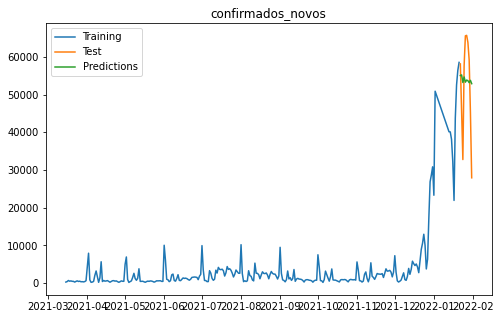

In [ ]:
# Plotando o gráfico incluindo dados de treino, teste, e predições.

plt.figure(figsize=(8,5))
plt.title(target_name)
plt.plot(y_train, label = 'Training')
plt.plot(y_test, label = 'Test')
plt.plot(df_prediction, label = 'Predictions')
plt.legend();

### Target: número de internados

In [ ]:
target_name = 'internados' #'internados_enfermaria'

y_train = df_train[[target_name]]
y_test = df_test[[target_name]]

y_train_prepared = numeric_pipeline.fit_transform(y_train)
y_test_prepared = numeric_pipeline.fit_transform(y_test)

In [ ]:
# Teste de estacionariedade
adf_test = ADFTest(alpha=0.05)
result_adf_test = adf_test.should_diff(y_train_prepared)

print('Resultado do teste: ', result_adf_test)

if result_adf_test[1] == 'True':
  print('\nDados estacionários')
else:
  print('Dados não estacionários, verificar parâmetro d no modelo')

Resultado do teste:  (0.01, False)
Dados não estacionários, verificar parâmetro d no modelo


In [ ]:
model_int = auto_arima(y=y_train_prepared, X=None, start_p=2, start_q=2,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=15, max_q=15, # maximum p and q
                      m=1,              # frequency of series
                      stationary=False,
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      information_criterion='aic',
                      alpha=0.05,
                      method='lbfgs', # default
                      scoring='mse' #'mae'
                  )

print(model_int.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4969.731, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5088.014, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5002.177, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4967.066, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5236.025, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4971.658, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4970.280, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4969.677, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5053.985, Time=0.14 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 2.026 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  302
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -2480.533
Date:                Sat, 19 Feb 2022   AIC      

In [ ]:
# Predições
y_predicted = model_int.predict(n_periods=len(y_test_prepared)) #, X=X_test_prepared)
print(y_predicted)

[1331.27689509  879.73480228  879.73480228  879.73480228  879.73480228
  879.73480228  879.73480228  879.73480228  879.73480228  879.73480228]


In [ ]:
# Comparação dos resultados

print('(Teste, Previsão) --- Previsão-Teste')

for pair in zip(np.reshape(y_test_prepared, len(y_test_prepared)), np.round(y_predicted,0)):
  print(pair, '---', pair[1]-pair[0])

(Teste, Previsão) --- Previsão-Teste
(2027.0, 1331.0) --- -696.0
(2219.0, 880.0) --- -1339.0
(2348.0, 880.0) --- -1468.0
(2320.0, 880.0) --- -1440.0
(2313.0, 880.0) --- -1433.0
(2249.0, 880.0) --- -1369.0
(2320.0, 880.0) --- -1440.0
(2292.0, 880.0) --- -1412.0
(2397.0, 880.0) --- -1517.0
(2469.0, 880.0) --- -1589.0


In [ ]:
# Métricas para o conjunto de testes
def test_metrics(y_pred, y_test):
  mae = mean_absolute_error(y_pred, y_test)
  mape = mean_absolute_percentage_error(y_pred, y_test)
  mse = mean_squared_error(y_pred, y_test)
  rmse = np.sqrt(mse)
      
  print(
        f"Mean Absolute Error (MAE):     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Mean Absolute Percentage Error (MAPE): {mape.mean():.3f} +/- {mape.std():.3f}\n"
        f"Mean Squared Error (MSE): {mse.mean():.3f} +/- {mse.std():.3f}\n"
        f"Root Mean Squared Error (RMSE): {rmse.mean():.3f} +/- {rmse.std():.3f}"
       )

print("Variável Alvo: ", target_name, '\n')  
test_metrics(y_predicted, y_test_prepared)

Variável Alvo:  internados 

Mean Absolute Error (MAE):     1370.511 +/- 0.000
Mean Absolute Percentage Error (MAPE): 1.531 +/- 0.000
Mean Squared Error (MSE): 1933367.913 +/- 0.000
Root Mean Squared Error (RMSE): 1390.456 +/- 0.000


In [ ]:
# Transformação do array de predições em df pandas para incluir no gráfico juntamente com os df de treino e teste
df_prediction = pd.DataFrame(y_predicted, index=y_test.index)
df_prediction.columns = [target_name]
df_prediction.head()

,internados
data,
2022-01-22,1331.276895
2022-01-23,879.734802
2022-01-24,879.734802
2022-01-25,879.734802
2022-01-26,879.734802


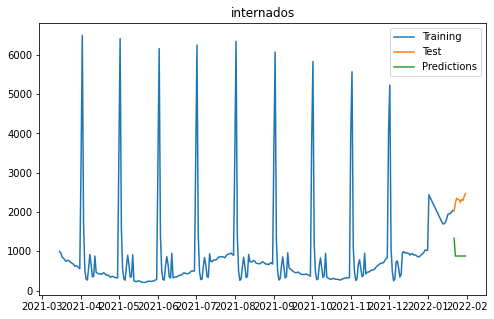

In [ ]:
# Plotando o gráfico incluindo dados de treino, teste, e predições.

plt.figure(figsize=(8,5))
plt.title(target_name)
plt.plot(y_train, label = 'Training')
plt.plot(y_test, label = 'Test')
plt.plot(df_prediction, label = 'Predictions')
plt.legend();

### Target: número de internados nas UTIs

In [ ]:
target_name = 'internados_uci'

y_train = df_train[[target_name]]
y_test = df_test[[target_name]]

y_train_prepared = numeric_pipeline.fit_transform(y_train)
y_test_prepared = numeric_pipeline.fit_transform(y_test)

In [ ]:
# Teste de estacionariedade
adf_test = ADFTest(alpha=0.05)
result_adf_test = adf_test.should_diff(y_train_prepared)

print('Resultado do teste: ', result_adf_test)

if result_adf_test[1] == 'True':
  print('\nDados estacionários')
else:
  print('Dados não estacionários, verificar parâmetro d no modelo')

Resultado do teste:  (0.01, False)
Dados não estacionários, verificar parâmetro d no modelo


In [ ]:
model_int_uti = auto_arima(y=y_train_prepared, X=None, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=15, max_q=15, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      information_criterion='aic',
                      scoring='mse' #'mae'
                  )

print("Variável Alvo: ", target_name, '\n')
print(model_int_uti.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3691.079, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3903.872, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3780.139, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3703.240, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4114.767, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3690.310, Time=1.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3720.594, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3691.994, Time=1.51 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3691.609, Time=0.77 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3690.588, Time=1.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3710.361, Time=0.34 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3693.609, Time=0.83 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3751.109, Time=0.33 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 7.588 seconds
Variável Alvo:  intern

In [ ]:
# Predições
y_predicted = model_int_uti.predict(n_periods=len(y_test_prepared)) #, X=X_test_prepared)
print(y_predicted)

[165.25363867 158.36928403 155.76551432 155.76252282 156.07658261
 156.17776897 156.17225653 156.15824468 156.15441331 156.15487854]


In [ ]:
# Comparação dos resultados

print('(Teste, Previsão) --- Previsão-Teste')

for pair in zip(np.reshape(y_test_prepared, len(y_test_prepared)), np.round(y_predicted,0)):
  print(pair, '---', pair[1]-pair[0])

(Teste, Previsão) --- Previsão-Teste
(154.0, 165.0) --- 11.0
(160.0, 158.0) --- -2.0
(172.0, 156.0) --- -16.0
(158.0, 156.0) --- -2.0
(154.0, 156.0) --- 2.0
(147.0, 156.0) --- 9.0
(152.0, 156.0) --- 4.0
(153.0, 156.0) --- 3.0
(160.0, 156.0) --- -4.0
(160.0, 156.0) --- -4.0


In [ ]:
# Métricas para o conjunto de testes
def test_metrics(y_pred, y_test):
  mae = mean_absolute_error(y_pred, y_test)
  mape = mean_absolute_percentage_error(y_pred, y_test)
  mse = mean_squared_error(y_pred, y_test)
  rmse = np.sqrt(mse)
      
  print(
        f"Mean Absolute Error (MAE):     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Mean Absolute Percentage Error (MAPE): {mape.mean():.3f} +/- {mape.std():.3f}\n"
        f"Mean Squared Error (MSE): {mse.mean():.3f} +/- {mse.std():.3f}\n"
        f"Root Mean Squared Error (RMSE): {rmse.mean():.3f} +/- {rmse.std():.3f}"
       )
  
print("Variável Alvo: ", target_name, '\n')
test_metrics(y_predicted, y_test_prepared)

Variável Alvo:  internados_uci 

Mean Absolute Error (MAE):     5.763 +/- 0.000
Mean Absolute Percentage Error (MAPE): 0.037 +/- 0.000
Mean Squared Error (MSE): 54.337 +/- 0.000
Root Mean Squared Error (RMSE): 7.371 +/- 0.000


In [ ]:
# Transformação do array de predições em df pandas para incluir no gráfico juntamente com os df de treino e teste
df_prediction = pd.DataFrame(y_predicted, index=y_test.index)
df_prediction.columns = [target_name]
df_prediction.head()

,internados_uci
data,
2022-01-22,165.253639
2022-01-23,158.369284
2022-01-24,155.765514
2022-01-25,155.762523
2022-01-26,156.076583


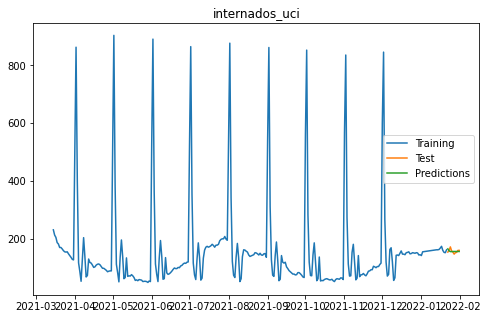

In [ ]:
# Plotando o gráfico incluindo dados de treino, teste, e predições.

plt.figure(figsize=(8,5))
plt.title(target_name)
plt.plot(y_train, label = 'Training')
plt.plot(y_test, label = 'Test')
plt.plot(df_prediction, label = 'Predictions')
plt.legend();

### Target: número de recuperados

In [ ]:
target_name = 'recuperados'

y_train = df_train[[target_name]]
y_test = df_test[[target_name]]

y_train_prepared = numeric_pipeline.fit_transform(y_train)
y_test_prepared = numeric_pipeline.fit_transform(y_test)

In [ ]:
# Teste de estacionariedade
adf_test = ADFTest(alpha=0.05)
result_adf_test = adf_test.should_diff(y_train_prepared)

print('Resultado do teste: ', result_adf_test)

if result_adf_test[1] == 'True':
  print('\nDados estacionários')
else:
  print('Dados não estacionários, verificar parâmetro d no modelo')

Resultado do teste:  (0.9422693227193227, True)
Dados não estacionários, verificar parâmetro d no modelo


In [ ]:
model_rcp = auto_arima( y=y_train_prepared, X=None, start_p=1, start_q=1,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=15, max_q=15, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=True,    # Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True,
                        information_criterion='aic',
                        scoring='mse' #'mae'
                      )

print("Variável Alvo: ", target_name, '\n')
print(model_rcp.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5755.324, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5822.652, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5792.069, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5761.235, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5820.726, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5757.870, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5757.250, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5757.816, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5774.824, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5758.787, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5754.877, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5759.769, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5790.253, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5755.801, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [ ]:
# Predições
y_predicted = model_rcp.predict(n_periods=len(y_test_prepared)) #, X=X_test_prepared)
print(y_predicted)

[23701.19398306 24957.51042753 24957.51042753 24957.51042753
 24957.51042753 24957.51042753 24957.51042753 24957.51042753
 24957.51042753 24957.51042753]


In [ ]:
# Comparação dos resultados

print('(Teste, Previsão) --- Previsão-Teste')

for pair in zip(np.reshape(y_test_prepared, len(y_test_prepared)), np.round(y_predicted,0)):
  print(pair, '---', pair[1]-pair[0])

(Teste, Previsão) --- Previsão-Teste
(26160.0, 23701.0) --- -2459.0
(10571.0, 24958.0) --- 14387.0
(12875.0, 24958.0) --- 12083.0
(54666.0, 24958.0) --- -29708.0
(62145.0, 24958.0) --- -37187.0
(23498.0, 24958.0) --- 1460.0
(42548.0, 24958.0) --- -17590.0
(46556.0, 24958.0) --- -21598.0
(39396.0, 24958.0) --- -14438.0
(39596.0, 24958.0) --- -14638.0


In [ ]:
# Métricas para o conjunto de testes
def test_metrics(y_pred, y_test):
  mae = mean_absolute_error(y_pred, y_test)
  mape = mean_absolute_percentage_error(y_pred, y_test)
  mse = mean_squared_error(y_pred, y_test)
  rmse = np.sqrt(mse)
      
  print(
        f"Mean Absolute Error (MAE):     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Mean Absolute Percentage Error (MAPE): {mape.mean():.3f} +/- {mape.std():.3f}\n"
        f"Mean Squared Error (MSE): {mse.mean():.3f} +/- {mse.std():.3f}\n"
        f"Root Mean Squared Error (RMSE): {rmse.mean():.3f} +/- {rmse.std():.3f}"
       )

print("Variável Alvo: ", target_name, '\n')  
test_metrics(y_predicted, y_test_prepared)

Variável Alvo:  recuperados 

Mean Absolute Error (MAE):     16554.927 +/- 0.000
Mean Absolute Percentage Error (MAPE): 0.664 +/- 0.000
Mean Squared Error (MSE): 382531380.492 +/- 0.000
Root Mean Squared Error (RMSE): 19558.409 +/- 0.000


In [ ]:
# Transformação do array de predições em df pandas para incluir no gráfico juntamente com os df de treino e teste
df_prediction = pd.DataFrame(y_predicted, index=y_test.index)
df_prediction.columns = [target_name]
df_prediction.head()

,recuperados
data,
2022-01-22,23701.193983
2022-01-23,24957.510428
2022-01-24,24957.510428
2022-01-25,24957.510428
2022-01-26,24957.510428


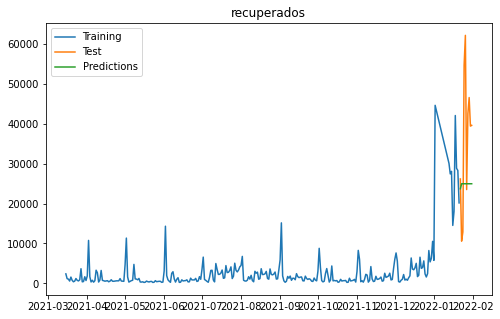

In [ ]:
# Plotando o gráfico incluindo dados de treino, teste, e predições.

plt.figure(figsize=(8,5))
plt.title(target_name)
plt.plot(y_train, label = 'Training')
plt.plot(y_test, label = 'Test')
plt.plot(df_prediction, label = 'Predictions')
plt.legend();